In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("oddrationale/mnist-in-csv")

print("Path to dataset files:", path)

100%|██████████| 15.2M/15.2M [00:06<00:00, 2.36MB/s]

Extracting files...


Path to dataset files: C:\Users\gedeb\.cache\kagglehub\datasets\oddrationale\mnist-in-csv\versions\2


### Intro to MNIST

In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv('mnist_train.csv')

# pisahkan label dan fitur
labels = df.iloc[:, 0].values
data = df.iloc[:, 1:].values.astype(np.float32)

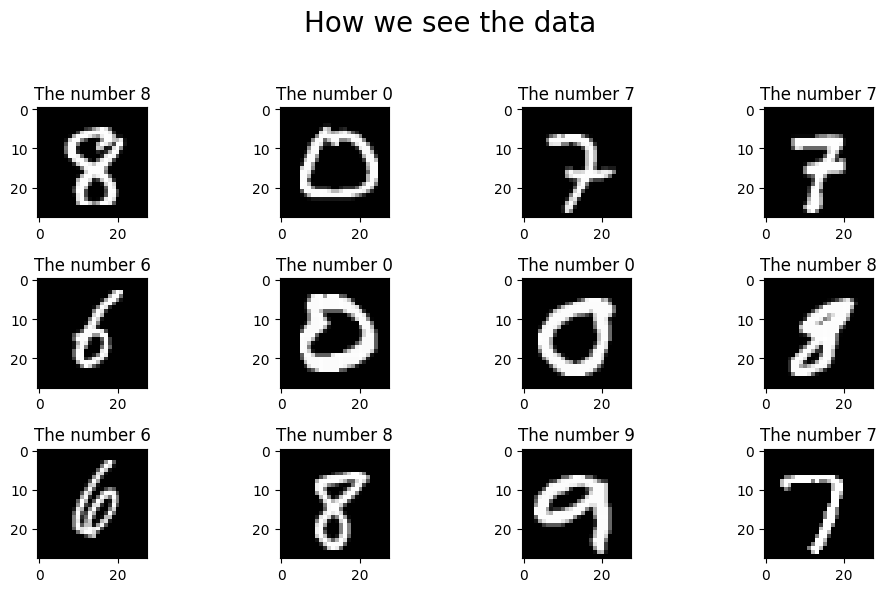

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
    randimg2show = np.random.randint(0, high=data.shape[0])

    # create the image (reshape inget)
    img = np.reshape(data[randimg2show, :], (28, 28))
    ax.imshow(img, cmap='gray')

    # title
    ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How we see the data', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

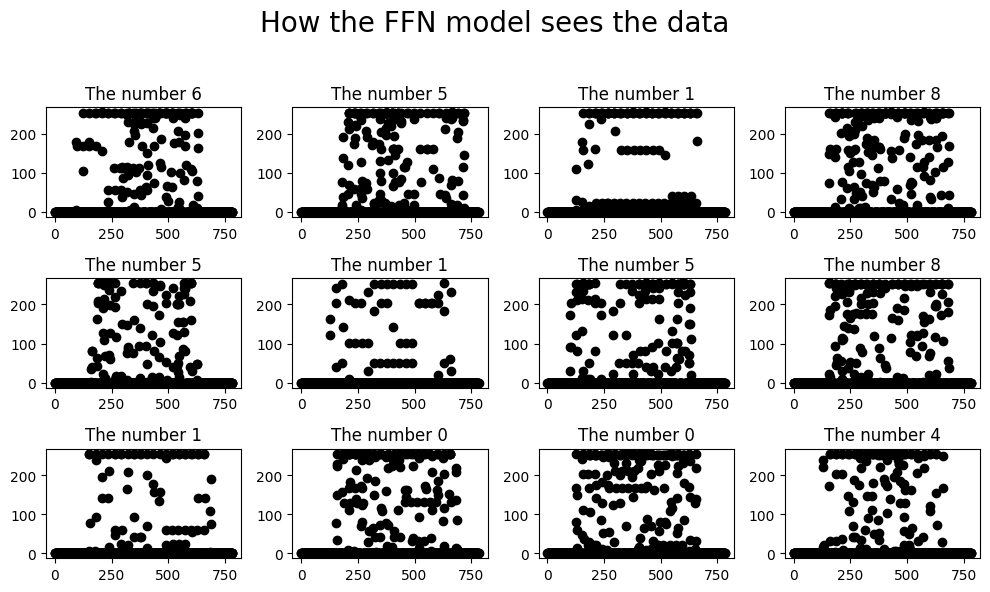

In [24]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image
  ax.plot(data[randimg2show,:],'ko')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How the FFN model sees the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()


### Data Normalization

In [25]:
data_norm = data / np.max(data)

In [26]:
# one hot encoding label
def one_hot_encode(y, num_classes=10):
    encoded = np.zeros((y.shape[0], num_classes))
    encoded[np.arange(y.shape[0]), y] = 1
    return encoded

labels_encoded = one_hot_encode(labels)

### Train and test data

In [30]:
def train_test_split(X, y, test_size=0.2, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # jumlah sample
    num_sample = X.shape[0]

    # array of index and do shuffling
    indices = np.arange(num_sample)
    np.random.shuffle(indices)

    # hitung jumlah test sample
    test_count = int(num_sample * test_size)

    # bagi index jadi test and train
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]

    # split data dan label sesuai index
    x_train = X[train_indices]
    y_train = y[train_indices]
    x_test = X[test_indices]
    y_test = y[test_indices]

    return x_train, x_test, y_train, y_test
    

In [32]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels_encoded, test_size=0.2, random_seed=42)

Siapkan batch loader untuk digunakan nanti

In [37]:
def batch_loader(X, y, batch_size=32, shuffle=True):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)

    if shuffle:
        np.random.shuffle(indices)

    for start_idx in range(0, num_samples, batch_size):
        end_idx = start_idx + batch_size
        batch_indices = indices[start_idx:end_idx]

        yield X[batch_indices], y[batch_indices]

### FFN Architecture

Input:       784 neuron  
Hidden 1:    128 neuron  
Hidden 2:    64 neuron  
Hidden 3:    32 neuron  
Output:      10 neuron (softmax)  

In [38]:
def init_weights():
    np.random.seed(42)

    W1 = np.random.randn(784, 128) * np.sqrt(1. / 784)
    b1 = np.zeros((1, 128))

    W2 = np.random.randn(128, 64) * np.sqrt(1. / 128)
    b2 = np.zeros((1, 64))

    W3 = np.random.randn(64, 32) * np.sqrt(1. / 64)
    b3 = np.zeros((1, 32))

    W4 = np.random.randn(32, 10) * np.sqrt(1. / 32)
    b4 = np.zeros((1, 10))

    return W1, b1, W2, b2, W3, b3, W4, b4

### ReLU and it's Derivative

In [39]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

### Softmax Function

In [40]:
def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)

### Forward Pass

In [50]:
def forward_pass(X, W1, b1, W2, b2, W3, b3, W4, b4):
    Z1 = X @ W1 + b1
    A1 = relu(Z1)

    Z2 = A1 @ W2 + b2
    A2 = relu(Z2)

    Z3 = A2 @ W3 + b3
    A3 = relu(Z3)

    Z4 = A3 @ W4 + b4
    A4 = softmax(Z4) # final prediction probabilities

    # simpan semua nilai Z dan A buat backward pass nanti
    cache = {
        'X': X,
        'Z1': Z1, 'A1': A1,
        'Z2': Z2, 'A2': A2,
        'Z3': Z3, 'A3': A3,
        'Z4': Z4, 'A4': A4,
    }

    return A4, cache


### Cross Entropy Loss Function

In [56]:
def cross_entropy_loss(y_true, y_pred):
    # hindari log(0) pake clip
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)

    # hitung loss
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

### Backward Pass

In [57]:
def backward_pass(y_true, cache, w1, w2, w3, w4):
    # unpack cache
    X = cache['X']
    Z1, A1 = cache['Z1'], cache['A1']
    Z2, A2 = cache['Z2'], cache['A2']
    Z3, A3 = cache['Z3'], cache['A3']
    Z4, A4 = cache['Z4'], cache['A4']
    batch_size = y_true.shape[0] 

    # output layer (softmax + cross-Entropy Derivative)
    dZ4 = (A4 - y_true) / batch_size
    dW4 = np.dot(A3.T, dZ4)
    db4 = np.sum(dZ4, axis=0, keepdims=True)

    # hidden layer 3
    dA3 = np.dot(dZ4, w4.T)
    dZ3 = dA3 * relu_derivative(Z3)
    dW3 = np.dot(A2.T, dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    # hidden layer 2
    dA2 = np.dot(dZ3, w3.T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    # hidden layer 1
    dA1 = np.dot(dZ2, w2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # return gradient
    grads = {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2,
        'dW3': dW3, 'db3': db3,
        'dW4': dW4, 'db4': db4
    }

    return grads


### Parameter Update setelah Backward Propagation

In [61]:
def update_parameters(w1, b1, w2, b2, w3, b3, w4, b4, grads, learning_rate=0.01):
    w1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']

    w2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']

    w3 -= learning_rate * grads['dW3']
    b3 -= learning_rate * grads['db3']

    w4 -= learning_rate * grads['dW4']
    b4 -= learning_rate * grads['db4']

    return w1, b1, w2, b2, w3, b3, w4, b4

In [62]:
def accuracy(y_true, y_pred):
    # y_true dan y_pred dalam bentuk one-hot (shape: [batch, 10])
    
    # Ambil kelas dengan probabilitas tertinggi
    true_labels = np.argmax(y_true, axis=1)
    pred_labels = np.argmax(y_pred, axis=1)

    # Hitung persentase label yang cocok
    acc = np.mean(true_labels == pred_labels)
    return acc


## Saatnya Training Loop Let's gooo

yang akan kita lakukan disini :
1. Loop semua batch dari `train_data`, `train_labels`
2. Forward pass
3. Hitung loss
4. Backward pass
5. Update parameter
6. Hitung akurasi

In [66]:
# setting up the hyperparametetr
epochs = 20
batch_size = 64
learning_rate = 0.01

# Neural Network parameter
W1, b1, W2, b2, W3, b3, W4, b4 = init_weights()

train_loss_list = []
train_acc_list = []

# training loop
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0

    for X_batch, y_batch in batch_loader(train_data, train_labels, batch_size=batch_size):
        # forward pass
        y_pred, cache = forward_pass(X_batch, W1, b1, W2, b2, W3, b3, W4, b4)

        # compute loss
        loss = cross_entropy_loss(y_batch, y_pred)
        epoch_loss += loss
        num_batches += 1

        # backward pass
        grads = backward_pass(y_batch, cache, W1, W2, W3, W4)

        # update parameters
        W1, b1, W2, b2, W3, b3, W4, b4 = update_parameters(
            W1, b1, W2, b2, W3, b3, W4, b4, grads, learning_rate
        )

    avg_loss = epoch_loss / num_batches
    y_test_pred, _ = forward_pass(test_data, W1, b1, W2, b2, W3, b3, W4, b4)
    test_acc = accuracy(test_labels, y_test_pred)

    train_loss_list.append(avg_loss)
    train_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {test_acc:.4f}")


Epoch 1/20 - Loss: 1.4126 - Accuracy: 0.8446
Epoch 2/20 - Loss: 0.4579 - Accuracy: 0.8928
Epoch 3/20 - Loss: 0.3486 - Accuracy: 0.9078
Epoch 4/20 - Loss: 0.3049 - Accuracy: 0.9165
Epoch 5/20 - Loss: 0.2754 - Accuracy: 0.9217
Epoch 6/20 - Loss: 0.2520 - Accuracy: 0.9295
Epoch 7/20 - Loss: 0.2314 - Accuracy: 0.9321
Epoch 8/20 - Loss: 0.2150 - Accuracy: 0.9391
Epoch 9/20 - Loss: 0.1993 - Accuracy: 0.9419
Epoch 10/20 - Loss: 0.1860 - Accuracy: 0.9447
Epoch 11/20 - Loss: 0.1739 - Accuracy: 0.9482
Epoch 12/20 - Loss: 0.1630 - Accuracy: 0.9492
Epoch 13/20 - Loss: 0.1527 - Accuracy: 0.9526
Epoch 14/20 - Loss: 0.1440 - Accuracy: 0.9540
Epoch 15/20 - Loss: 0.1364 - Accuracy: 0.9563
Epoch 16/20 - Loss: 0.1296 - Accuracy: 0.9583
Epoch 17/20 - Loss: 0.1233 - Accuracy: 0.9588
Epoch 18/20 - Loss: 0.1170 - Accuracy: 0.9606
Epoch 19/20 - Loss: 0.1108 - Accuracy: 0.9611
Epoch 20/20 - Loss: 0.1063 - Accuracy: 0.9637


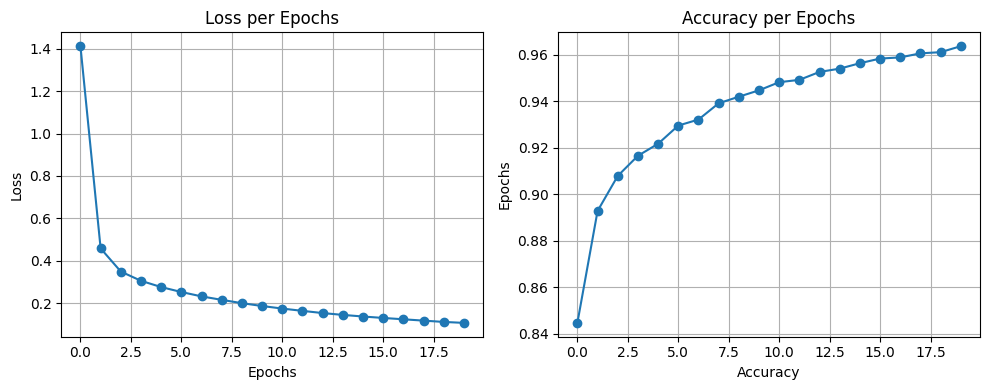

In [70]:
plt.figure(figsize=(10, 4))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, marker='o')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.tight_layout()
plt.grid()


plt.show()

## Model Evaluation

1. Buat confusion matrix: lihat kelas mana yang paling sering salah
2. Hitung precision, recall, dan F1-score per kelas
3. Cek contoh-contoh prediksi yang salah

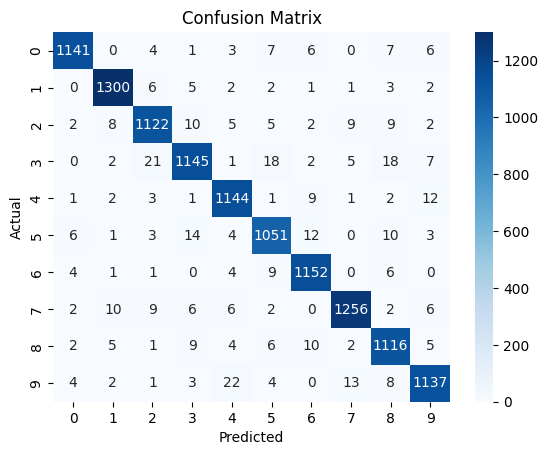

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = np.argmax(test_labels, axis=1)
pred_labels = np.argmax(y_test_pred, axis=1)

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

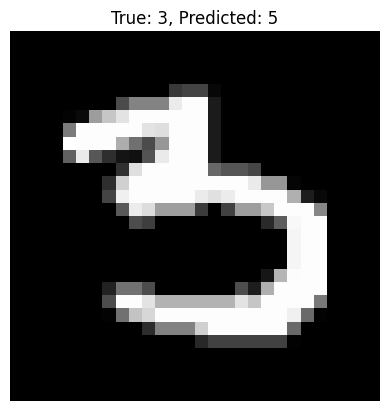

In [78]:
import matplotlib.pyplot as plt

def show_prediction(index):
    image = test_data[index].reshape(28, 28)
    true_label = np.argmax(test_labels[index])
    pred_label = np.argmax(y_test_pred[index])

    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

# Contoh: tampilkan prediksi untuk gambar ke-5
show_prediction(180)

### Liat prediksi yang salah dari model

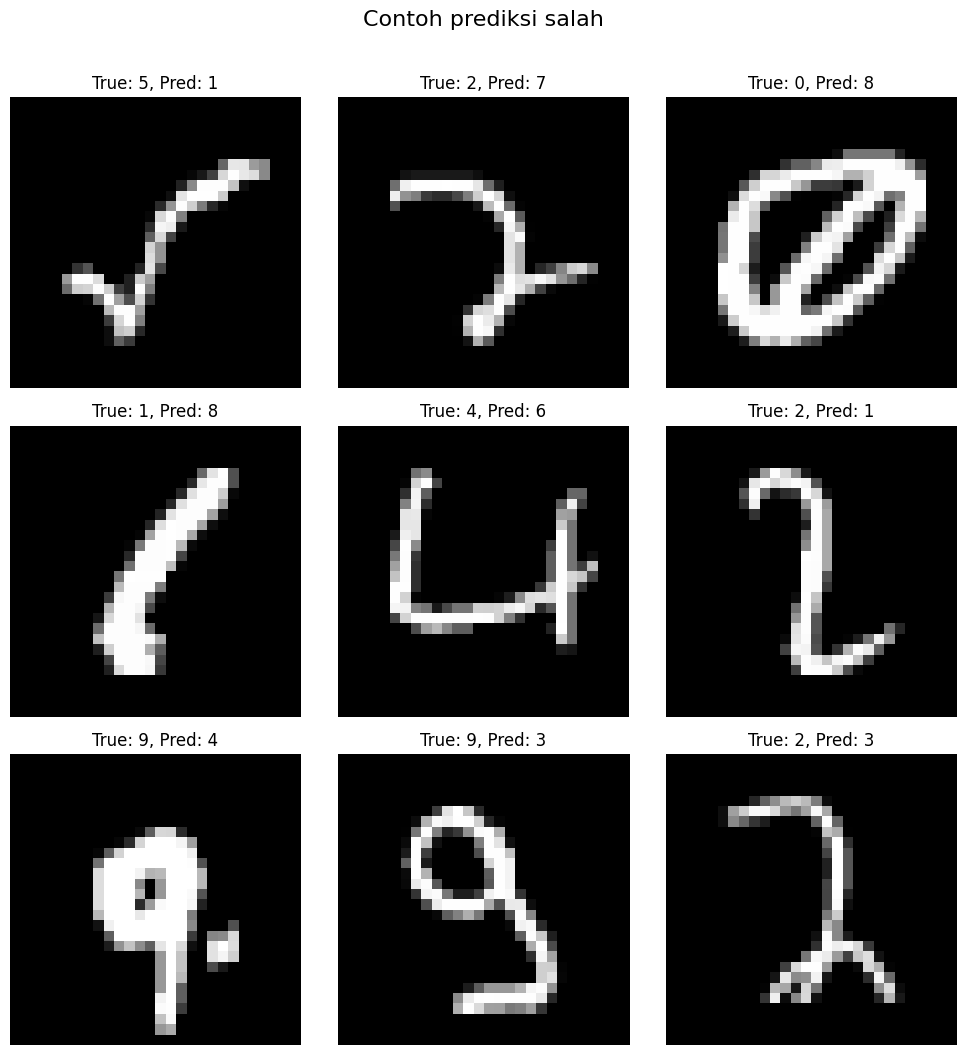

In [79]:
wrong_mask = true_labels != pred_labels

# ambil indexnya
wrong_indices = np.where(wrong_mask)[0]

def show_wrong_predictions(data, true_labels, pred_labels, indices, count=9):
    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices[:count]):
        image = data[idx].reshape(28, 28)
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]

        plt.subplot(3, 3, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {true_label}, Pred: {pred_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Contoh prediksi salah', fontsize=16, y=1.05)
    plt.show()

show_wrong_predictions(test_data, true_labels, pred_labels, wrong_indices)

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='macro')
rec = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9637
Precision: 0.9633
Recall:    0.9634
F1 Score:  0.9633


In [82]:
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9819    0.9711    0.9765      1175
           1     0.9767    0.9834    0.9800      1322
           2     0.9582    0.9557    0.9569      1174
           3     0.9590    0.9393    0.9490      1219
           4     0.9573    0.9728    0.9650      1176
           5     0.9511    0.9520    0.9516      1104
           6     0.9648    0.9788    0.9717      1177
           7     0.9759    0.9669    0.9714      1299
           8     0.9450    0.9621    0.9534      1160
           9     0.9636    0.9523    0.9579      1194

    accuracy                         0.9637     12000
   macro avg     0.9633    0.9634    0.9633     12000
weighted avg     0.9637    0.9637    0.9637     12000



In [83]:
import pickle

model = {'w1': W1, 'b1': b1, 'w2': W2, 'b2': b2, 'w3': W3, 'b3': b3, 'w4': W4, 'b4': b4}
with open("model_ffn.pkl", "wb") as f:
    pickle.dump(model, f)